In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jena-climate/jena_climate_2009_2016.csv


In [46]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [24]:
data = pd.read_csv("/kaggle/input/jena-climate/jena_climate_2009_2016.csv")
data.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [25]:
df = data[["Date Time", "p (mbar)","Tpot (K)", "sh (g/kg)"]].rename(columns={"Date Time": "DateTime", "p (mbar)":"pressure", "Tpot (K)": "temperature", "sh (g/kg)":"humidity"})
df.head(3)

,DateTime,pressure,temperature,humidity
0,01.01.2009 00:10:00,996.52,265.40,1.94
1,01.01.2009 00:20:00,996.57,265.01,1.89
2,01.01.2009 00:30:00,996.53,264.91,1.88


In [26]:
df["DateTime"] = pd.to_datetime(df.DateTime, format="%d.%m.%Y %H:%M:%S")
df["date"] = df["DateTime"].dt.date
df.head(5)

,DateTime,pressure,temperature,humidity,date
0,2009-01-01 00:10:00,996.52,265.40,1.94,2009-01-01
1,2009-01-01 00:20:00,996.57,265.01,1.89,2009-01-01
2,2009-01-01 00:30:00,996.53,264.91,1.88,2009-01-01
3,2009-01-01 00:40:00,996.51,265.12,1.92,2009-01-01
4,2009-01-01 00:50:00,996.51,265.15,1.92,2009-01-01


In [27]:
dailydf = df[["date","pressure", "temperature", "humidity"]].groupby(by="date").mean().reset_index()
dailydf.head(5)

,date,pressure,temperature,humidity
0,2009-01-01,999.145594,266.414545,2.091049
1,2009-01-02,999.600625,269.463194,2.659792
2,2009-01-03,998.548611,268.002292,1.937778
3,2009-01-04,988.510694,272.685347,3.114028
4,2009-01-05,990.405694,269.039306,2.397014


In [28]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [58]:
dataset = dailydf[["pressure", "temperature", "humidity"]]

In [59]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [60]:
# split into train and test sets
train_size = int(len(dataset) - 7*6)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

train_dates = dailydf["date"][0:train_size]
test_dates = dailydf["date"][train_size:len(dataset)]

print(len(train), len(test))

2879 42


In [32]:
pressure_train = train[:,0]
temp_train = train[:,1]
humidity_train = train[:,2]

pressure_test = test[:,0]
temp_test = test[:,1]
humidity_test = test[:,2]

In [33]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, out_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-out_window):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        b = dataset[(i + look_back):(i + look_back + out_window)]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [34]:
X, Y = create_dataset(pressure_test, look_back=14, out_window=7)
print(X[1:5])
print(Y[1:5])

[[0.55966933 0.66009298 0.71236639 0.72714435 0.67195148 0.64669297
  0.80552613 0.89514425 0.82401462 0.69922508 0.6708301  0.77282305
  0.82369712 0.79710769]
 [0.66009298 0.71236639 0.72714435 0.67195148 0.64669297 0.80552613
  0.89514425 0.82401462 0.69922508 0.6708301  0.77282305 0.82369712
  0.79710769 0.85592449]
 [0.71236639 0.72714435 0.67195148 0.64669297 0.80552613 0.89514425
  0.82401462 0.69922508 0.6708301  0.77282305 0.82369712 0.79710769
  0.85592449 0.8774201 ]
 [0.72714435 0.67195148 0.64669297 0.80552613 0.89514425 0.82401462
  0.69922508 0.6708301  0.77282305 0.82369712 0.79710769 0.85592449
  0.8774201  0.82639102]]
[[0.85592449 0.8774201  0.82639102 0.79671644 0.72920646 0.62775764
  0.72934864]
 [0.8774201  0.82639102 0.79671644 0.72920646 0.62775764 0.72934864
  0.76417798]
 [0.82639102 0.79671644 0.72920646 0.62775764 0.72934864 0.76417798
  0.75839679]
 [0.79671644 0.72920646 0.62775764 0.72934864 0.76417798 0.75839679
  0.82315941]]


In [35]:
look_back = 14
out_window = 7
pressure_trainX, pressure_trainY = create_dataset(pressure_train, look_back, out_window)
temp_trainX, temp_trainY = create_dataset(temp_train, look_back, out_window)
humidity_trainX, humidity_trainY = create_dataset(humidity_train, look_back, out_window)

In [36]:
# reshape input to be [samples, time steps, features]
pressure_trainX = np.reshape(pressure_trainX, (pressure_trainX.shape[0], 1, pressure_trainX.shape[1]))

temp_trainX = np.reshape(temp_trainX, (temp_trainX.shape[0], 1, temp_trainX.shape[1]))

humidity_trainX = np.reshape(humidity_trainX, (humidity_trainX.shape[0], 1, humidity_trainX.shape[1]))

In [37]:
w1 = temp_train[-look_back:]
w2 = np.concatenate([temp_train[-(look_back-out_window):],temp_test[0:out_window]])
w3 = temp_test[0:look_back]
w4 = temp_test[7:7+14]
w5 = temp_test[14:14+14]
w6 = temp_test[21:21+14]
temp_testX = np.array([w1,w2,w3,w4,w5,w6])
temp_testX = np.reshape(temp_testX, (temp_testX.shape[0], 1, temp_testX.shape[1]))

In [38]:
w1 = pressure_train[-look_back:]
w2 = np.concatenate([pressure_train[-(look_back-out_window):],pressure_test[0:out_window]])
w3 = pressure_test[0:look_back]
w4 = pressure_test[7:7+14]
w5 = pressure_test[14:14+14]
w6 = pressure_test[21:21+14]
pressure_testX = np.array([w1,w2,w3,w4,w5,w6])
pressure_testX = np.reshape(pressure_testX, (pressure_testX.shape[0], 1, pressure_testX.shape[1]))

In [39]:
w1 = humidity_train[-look_back:]
w2 = np.concatenate([humidity_train[-(look_back-out_window):],humidity_test[0:out_window]])
w3 = humidity_test[0:look_back]
w4 = humidity_test[7:7+14]
w5 = humidity_test[14:14+14]
w6 = humidity_test[21:21+14]
humidity_testX = np.array([w1,w2,w3,w4,w5,w6])
humidity_testX = np.reshape(humidity_testX, (humidity_testX.shape[0], 1, humidity_testX.shape[1]))

# Pressure

In [40]:
# create and fit the LSTM network
model_pressure = Sequential()
model_pressure.add(LSTM(10, input_shape=(1, look_back)))
model_pressure.add(Dense(out_window))
model_pressure.compile(loss='mean_squared_error', optimizer='adam')
model_pressure.fit(pressure_trainX, pressure_trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
2858/2858 - 7s - loss: 0.0195 - 7s/epoch - 3ms/step
Epoch 2/100
2858/2858 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 3/100
2858/2858 - 6s - loss: 0.0135 - 6s/epoch - 2ms/step
Epoch 4/100
2858/2858 - 6s - loss: 0.0132 - 6s/epoch - 2ms/step
Epoch 5/100
2858/2858 - 6s - loss: 0.0130 - 6s/epoch - 2ms/step
Epoch 6/100
2858/2858 - 6s - loss: 0.0129 - 6s/epoch - 2ms/step
Epoch 7/100
2858/2858 - 6s - loss: 0.0129 - 6s/epoch - 2ms/step
Epoch 8/100
2858/2858 - 6s - loss: 0.0129 - 6s/epoch - 2ms/step
Epoch 9/100
2858/2858 - 6s - loss: 0.0128 - 6s/epoch - 2ms/step
Epoch 10/100
2858/2858 - 6s - loss: 0.0128 - 6s/epoch - 2ms/step
Epoch 11/100
2858/2858 - 6s - loss: 0.0128 - 6s/epoch - 2ms/step
Epoch 12/100
2858/2858 - 6s - loss: 0.0127 - 6s/epoch - 2ms/step
Epoch 13/100
2858/2858 - 5s - loss: 0.0128 - 5s/epoch - 2ms/step
Epoch 14/100
2858/2858 - 6s - loss: 0.0128 - 6s/epoch - 2ms/step
Epoch 15/100
2858/2858 - 6s - loss: 0.0127 - 6s/epoch - 2ms/step
Epoch 16/100
2858/2858 - 5s - loss

In [41]:
pressure_forecasts = model_pressure.predict(pressure_testX, batch_size=10)
pressure_forecasts

1/1 [==============================] - 0s 421ms/step


array([[0.46456236, 0.5096146 , 0.5365749 , 0.56036043, 0.5758063 ,
        0.5876053 , 0.593605  ],
       [0.6390214 , 0.6303675 , 0.61722064, 0.61808413, 0.6159782 ,
        0.61873496, 0.6163024 ],
       [0.78152233, 0.72331583, 0.6768903 , 0.6630265 , 0.65353787,
        0.6494371 , 0.63557744],
       [0.5812743 , 0.59754884, 0.6060806 , 0.6099965 , 0.6158105 ,
        0.61947894, 0.6170068 ],
       [0.8093133 , 0.7455169 , 0.6955111 , 0.67541105, 0.6660129 ,
        0.66341215, 0.6489687 ],
       [0.69045836, 0.6689941 , 0.65084183, 0.6424422 , 0.63926953,
        0.63869107, 0.63074136]], dtype=float32)

In [156]:
def evaluate_forecasts(test, forecasts, n_seq):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print('%d RMSE: %f' % ((i+1), rmse))

In [ ]:
evaluate_forecasts(pressure_test, pressure_forecasts, 6)

# Temperature

In [42]:
# create and fit the LSTM network
model_temp = Sequential()
model_temp.add(LSTM(10, input_shape=(1, look_back)))
model_temp.add(Dense(out_window))
model_temp.compile(loss='mean_squared_error', optimizer='adam')
model_temp.fit(temp_trainX, temp_trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
2858/2858 - 7s - loss: 0.0152 - 7s/epoch - 3ms/step
Epoch 2/100
2858/2858 - 7s - loss: 0.0083 - 7s/epoch - 2ms/step
Epoch 3/100
2858/2858 - 7s - loss: 0.0081 - 7s/epoch - 2ms/step
Epoch 4/100
2858/2858 - 6s - loss: 0.0079 - 6s/epoch - 2ms/step
Epoch 5/100
2858/2858 - 6s - loss: 0.0078 - 6s/epoch - 2ms/step
Epoch 6/100
2858/2858 - 6s - loss: 0.0077 - 6s/epoch - 2ms/step
Epoch 7/100
2858/2858 - 6s - loss: 0.0077 - 6s/epoch - 2ms/step
Epoch 8/100
2858/2858 - 6s - loss: 0.0076 - 6s/epoch - 2ms/step
Epoch 9/100
2858/2858 - 6s - loss: 0.0075 - 6s/epoch - 2ms/step
Epoch 10/100
2858/2858 - 6s - loss: 0.0075 - 6s/epoch - 2ms/step
Epoch 11/100
2858/2858 - 6s - loss: 0.0074 - 6s/epoch - 2ms/step
Epoch 12/100
2858/2858 - 6s - loss: 0.0075 - 6s/epoch - 2ms/step
Epoch 13/100
2858/2858 - 6s - loss: 0.0074 - 6s/epoch - 2ms/step
Epoch 14/100
2858/2858 - 6s - loss: 0.0074 - 6s/epoch - 2ms/step
Epoch 15/100
2858/2858 - 6s - loss: 0.0074 - 6s/epoch - 2ms/step
Epoch 16/100
2858/2858 - 6s - loss

In [43]:
temp_forecasts = model_temp.predict(temp_testX, batch_size=10)
temp_forecasts

1/1 [==============================] - 1s 663ms/step


array([[0.56692356, 0.5527869 , 0.5447787 , 0.52863085, 0.52211094,
        0.5165386 , 0.51775926],
       [0.46702784, 0.46392703, 0.46500266, 0.45719275, 0.45985448,
        0.4642629 , 0.4724686 ],
       [0.28844213, 0.3192485 , 0.3474152 , 0.3508693 , 0.35430422,
        0.36465022, 0.38774472],
       [0.5016942 , 0.4877845 , 0.47882295, 0.46446428, 0.46002632,
        0.45763284, 0.45770073],
       [0.43746716, 0.4286617 , 0.4205774 , 0.40870684, 0.40979528,
        0.41261855, 0.4154399 ],
       [0.52732635, 0.5016411 , 0.48572123, 0.47550017, 0.48525277,
        0.48371893, 0.47892347]], dtype=float32)

In [ ]:
evaluate_forecasts(temp_test, pressure_forecasts, 6)

# Humidity

In [44]:
# create and fit the LSTM network
model_humidity = Sequential()
model_humidity.add(LSTM(10, input_shape=(1, look_back)))
model_humidity.add(Dense(out_window))
model_humidity.compile(loss='mean_squared_error', optimizer='adam')
model_humidity.fit(humidity_trainX, humidity_trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
2858/2858 - 8s - loss: 0.0152 - 8s/epoch - 3ms/step
Epoch 2/100
2858/2858 - 7s - loss: 0.0110 - 7s/epoch - 2ms/step
Epoch 3/100
2858/2858 - 6s - loss: 0.0108 - 6s/epoch - 2ms/step
Epoch 4/100
2858/2858 - 6s - loss: 0.0107 - 6s/epoch - 2ms/step
Epoch 5/100
2858/2858 - 6s - loss: 0.0106 - 6s/epoch - 2ms/step
Epoch 6/100
2858/2858 - 6s - loss: 0.0105 - 6s/epoch - 2ms/step
Epoch 7/100
2858/2858 - 6s - loss: 0.0105 - 6s/epoch - 2ms/step
Epoch 8/100
2858/2858 - 6s - loss: 0.0104 - 6s/epoch - 2ms/step
Epoch 9/100
2858/2858 - 6s - loss: 0.0104 - 6s/epoch - 2ms/step
Epoch 10/100
2858/2858 - 6s - loss: 0.0104 - 6s/epoch - 2ms/step
Epoch 11/100
2858/2858 - 7s - loss: 0.0103 - 7s/epoch - 2ms/step
Epoch 12/100
2858/2858 - 7s - loss: 0.0104 - 7s/epoch - 2ms/step
Epoch 13/100
2858/2858 - 6s - loss: 0.0103 - 6s/epoch - 2ms/step
Epoch 14/100
2858/2858 - 6s - loss: 0.0102 - 6s/epoch - 2ms/step
Epoch 15/100
2858/2858 - 7s - loss: 0.0103 - 7s/epoch - 2ms/step
Epoch 16/100
2858/2858 - 6s - loss

In [45]:
humidity_forecasts = model_humidity.predict(humidity_testX, batch_size=10)
humidity_forecasts

1/1 [==============================] - 0s 346ms/step


array([[0.26640928, 0.2676956 , 0.2649424 , 0.25464934, 0.24424675,
        0.25516778, 0.25298598],
       [0.2663317 , 0.27024508, 0.26589763, 0.25628853, 0.2509028 ,
        0.25367495, 0.26168483],
       [0.15050401, 0.15684898, 0.1714007 , 0.17407197, 0.17159112,
        0.18596262, 0.19312505],
       [0.26817155, 0.25116497, 0.24531749, 0.24033418, 0.22793393,
        0.23452516, 0.23292482],
       [0.27353227, 0.2634127 , 0.2461668 , 0.22821508, 0.22066543,
        0.22259362, 0.22933058],
       [0.3030905 , 0.27626884, 0.26191014, 0.25079253, 0.2482054 ,
        0.25785694, 0.26524654]], dtype=float32)

In [175]:
evaluate_forecasts(humidity_testY, humidity_forecasts, 6)

1 RMSE: 0.110881
2 RMSE: 0.087598
3 RMSE: 0.090285
4 RMSE: 0.053711
5 RMSE: 0.045714
6 RMSE: 0.049216


# Compare forecasts

In [66]:
predictions = pd.DataFrame({"date": test_dates, "pressure_pred": pressure_forecasts.reshape(42), "temp_pred": temp_forecasts.reshape(42), "humidity_pred": humidity_forecasts.reshape(42)})
predictions[["pressure_pred", "temp_pred", "humidity_pred"]] = scaler.inverse_transform(predictions[["pressure_pred", "temp_pred", "humidity_pred"]])
predictions.head(5)

,date,pressure_pred,temp_pred,humidity_pred
2879,2016-11-21,979.174683,282.760803,4.617891
2880,2016-11-22,982.101318,282.096100,4.636274
2881,2016-11-23,983.852722,281.719543,4.596928
2882,2016-11-24,985.397888,280.960297,4.449830
2883,2016-11-25,986.401245,280.653717,4.301166


In [70]:
pressure_train_ts = dailydf["pressure"][0:train_size]
pressure_test_ts = dailydf["pressure"][train_size:len(dataset)]

temp_train_ts = dailydf["temperature"][0:train_size]
temp_test_ts = dailydf["temperature"][train_size:len(dataset)]

humidity_train_ts = dailydf["humidity"][0:train_size]
humidity_test_ts = dailydf["humidity"][train_size:len(dataset)]

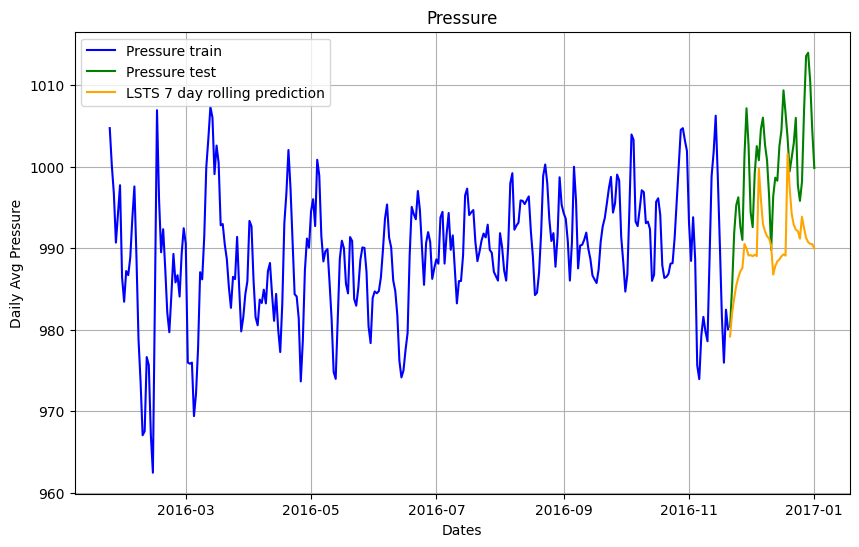

In [93]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Daily Avg Pressure')
plt.plot(train_dates[-300:],pressure_train_ts[-300:], 'blue', label='Pressure train')
plt.plot(predictions.date, pressure_test_ts, 'g', label='Pressure test')
plt.plot(predictions.date, predictions.pressure_pred, 'orange', label='LSTS 7 day rolling prediction')
plt.title("Pressure")
plt.legend()

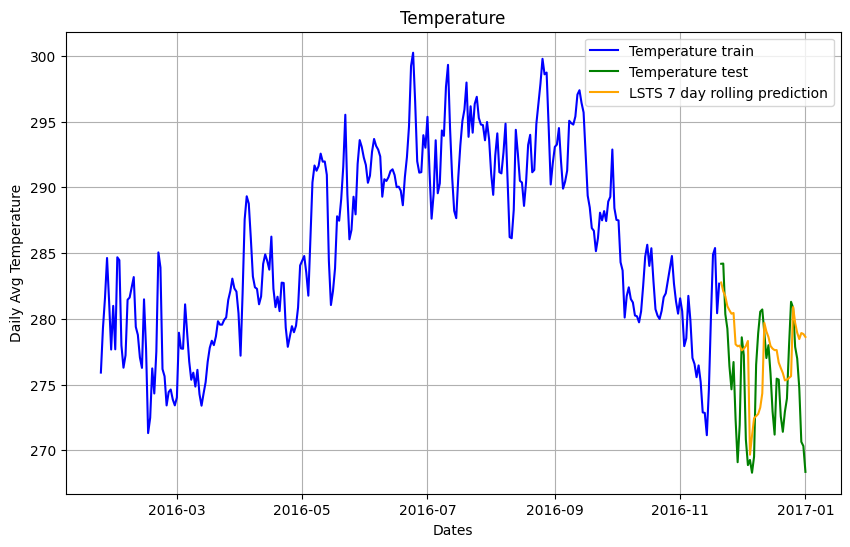

In [92]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Daily Avg Temperature')
plt.plot(train_dates[-300:],temp_train_ts[-300:], 'blue', label='Temperature train')
plt.plot(predictions.date, temp_test_ts, 'g', label='Temperature test')
plt.plot(predictions.date, predictions.temp_pred, 'orange', label='LSTS 7 day rolling prediction')
plt.title("Temperature")
plt.legend()

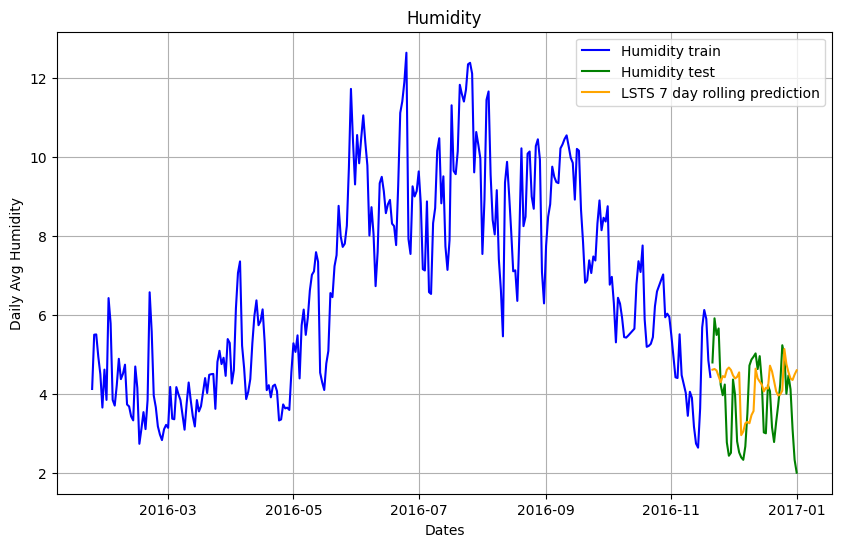

In [94]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Daily Avg Humidity')
plt.plot(train_dates[-300:],humidity_train_ts[-300:], 'blue', label='Humidity train')
plt.plot(predictions.date, humidity_test_ts, 'g', label='Humidity test')
plt.plot(predictions.date, predictions.humidity_pred, 'orange', label='LSTS 7 day rolling prediction')
plt.title("Humidity")
plt.legend()

In [101]:
mae1 = np.mean(np.abs(predictions.pressure_pred - pressure_test_ts))
pm1 = np.sum(np.square(predictions.pressure_pred - pressure_test_ts))/np.sum(np.square(pressure_test_ts-np.mean(pressure_test_ts)))

print("MAE for Pressure Prediction is", mae1)
print("PM for Pressure Prediction is", pm1)

MAE for Pressure Prediction is 9.83366799329323
PM for Pressure Prediction is 2.7672238311178115


In [102]:
mae2 = np.mean(np.abs(predictions.temp_pred - temp_test_ts))
pm2 = np.sum(np.square(predictions.temp_pred - temp_test_ts))/np.sum(np.square(temp_test_ts-np.mean(temp_test_ts)))

print("MAE for Temperature Prediction is", mae2)
print("PM for Temperature Prediction is", pm2)

MAE for Temperature Prediction is 3.895369462916464
PM for Temperature Prediction is 1.2209059965491076


In [103]:
mae3 = np.mean(np.abs(predictions.humidity_pred - humidity_test_ts))
pm3 = np.sum(np.square(predictions.humidity_pred - humidity_test_ts))/np.sum(np.square(humidity_test_ts-np.mean(humidity_test_ts)))

print("MAE for Humidity Prediction is", mae3)
print("PM for Humidity Prediction is", pm3)

MAE for Humidity Prediction is 0.9026328788484845
PM for Humidity Prediction is 1.2010388555587788
